In [7]:
clear

In [8]:
import coax
import gym
import haiku as hk
import jax
import jax.numpy as jnp
import optax
from coax.value_losses import mse
import matplotlib.pyplot as plt

In [9]:
%matplotlib widget

In [10]:
import RLcircuit

ModuleNotFoundError: No module named 'RLcircuit'

In [ ]:
env = gym.make('foo-v0')
env.init_2(0.5, 1, 0.1)
env.spec.max_episode_steps = 100
env.spec.reward_threshold = 250
env = coax.wrappers.TrainMonitor(env, name='firstOrder', tensorboard_dir=f"./data/tensorboard/firstOrder")

In [ ]:
def func_pi(S, is_training):
    logits = hk.Sequential((
        hk.Linear(128), jax.nn.relu,
        hk.Linear(env.action_space.n, w_init=jnp.zeros)
    ))
    return {'logits': logits(S)}


def func_v(S, is_training):
    value = hk.Sequential((
        hk.Linear(128), jax.nn.relu,
        hk.Linear(1, w_init=jnp.zeros), jnp.ravel
    ))
    return value(S)

In [ ]:
# these optimizers collect batches of grads before applying updates
optimizer_v = optax.chain(optax.apply_every(k=32), optax.adam(0.002*10))
optimizer_pi = optax.chain(optax.apply_every(k=32), optax.adam(0.001/10))


# value function and its derived policy
v = coax.V(func_v, env)
pi = coax.Policy(func_pi, env)

# experience tracer
tracer = coax.reward_tracing.NStep(n=1, gamma=0.1)

# updaters
vanilla_pg = coax.policy_objectives.VanillaPG(pi, optimizer=optimizer_pi)
simple_td = coax.td_learning.SimpleTD(v, loss_function=mse, optimizer=optimizer_v)

In [5]:
#simple_td._optimizer_state[0][1]

In [6]:
avgG_h = []
loss_h = []

# train
for ep in range(500):
    s = env.reset()

    for t in range(env.spec.max_episode_steps):
        a = pi(s)
        s_next, r, done, info = env.step(a)
        if done and (t == env.spec.max_episode_steps - 1):
            r = 1 / (1 - tracer.gamma)

        tracer.add(s, a, r, done)
        while tracer:
            transition_batch = tracer.pop()
            metrics_v, td_error = simple_td.update(transition_batch, return_td_error=True)
            metrics_pi = vanilla_pg.update(transition_batch, td_error)
            env.record_metrics(metrics_v)
            env.record_metrics(metrics_pi)

        if done:
            break

        s = s_next

    # Saving data
    loss_h.append([float(env._ep_metrics['VanillaPG/loss'][0]), float(env._ep_metrics['SimpleTD/loss'][0])])
    avgG_h.append(env.G)
    
    # early stopping
    #if env.G > env.spec.reward_threshold:
    #    break



NameError: name 'env' is not defined

In [10]:
#simple_td._optimizer_state[0][1]

In [11]:
#vanilla_pg._optimizer_state[0][1]

[firstOrder|TrainMonitor|INFO] ep: 504,	T: 54,504,	G: 3.53e+03,	avg_r: 3.53,	avg_G: 0,	t: 1000,	dt: 16.065ms


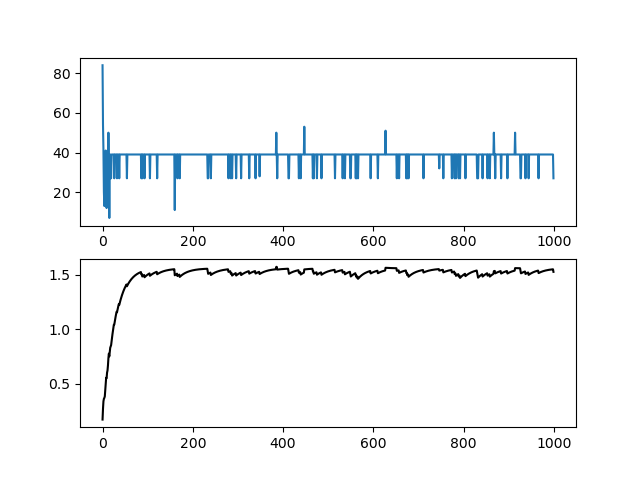

In [17]:
s = env.reset()
s_history = []
a_history = []
r_history = []

for t in range(env.spec.max_episode_steps*10):
    a = pi(s)
    action_dist = pi.dist_params(s)
    #print(action_dist)
    #a = np.argmax(action_dist['logits'])
    
    s_next, r, done, info = env.step(a)
        
    s_history.append(s[0])
    a_history.append(a)
    r_history.append(r)
    
    s = s_next
    

fig, ax = plt.subplots(2, 1)
ax[0].plot(a_history)
ax[1].plot(s_history, 'k')

Text(0.5, 0, 'episode')

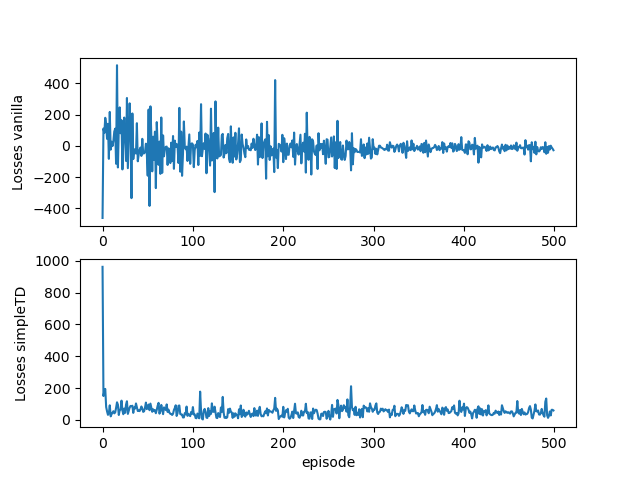

In [13]:
fig, ax = plt.subplots(2, 1)

#ax[0].plot(avgG_h)
#ax[0].set_ylabel('G')
ax[0].plot([item[0] for item in loss_h])
ax[0].set_ylabel('Losses vanilla')
ax[1].plot([item[1] for item in loss_h])
ax[1].set_ylabel('Losses simpleTD')
ax[1].set_xlabel('episode')